# Obesity Multiclass Classification with XGBoost

## 1. Import all libraries required

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

## Read dataset and mapping the target

In [2]:
obesity = pd.read_csv("obesity.csv")

# change the target name from "NObeyesdad" to "target"
obesity.rename(columns={"NObeyesdad": "Target"}, inplace=True)

target_map = {
    "Insufficient_Weight": 0,
    "Normal_Weight": 1,
    "Overweight_Level_I": 2,
    "Overweight_Level_II": 3,
    "Obesity_Type_I": 4,
    "Obesity_Type_II": 5,
    "Obesity_Type_III": 6
}
obesity["Target"] = obesity["Target"].map(target_map)

X = obesity.drop(columns=["Target"])
y = obesity["Target"]

In [3]:
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Target
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,1
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,1
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,2
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,3


## 3. Identify the type of features and do split train test

In [4]:
# Identify types
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 4. Create the preprocessing pipeline

In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit transform on train, transform on test
X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)

## 5. Assign XGBoost for multiclass classification with xgboost.cv() for hyperparameter tunning

[0]	train-mlogloss:1.71741+0.00236	test-mlogloss:1.73288+0.00547
[50]	train-mlogloss:0.10165+0.00122	test-mlogloss:0.19693+0.01301
[100]	train-mlogloss:0.04064+0.00063	test-mlogloss:0.13559+0.01437
[150]	train-mlogloss:0.02932+0.00045	test-mlogloss:0.12510+0.01496
[200]	train-mlogloss:0.02461+0.00034	test-mlogloss:0.12160+0.01587
[250]	train-mlogloss:0.02198+0.00030	test-mlogloss:0.12025+0.01585
[300]	train-mlogloss:0.02027+0.00025	test-mlogloss:0.11935+0.01589
[350]	train-mlogloss:0.01901+0.00021	test-mlogloss:0.11867+0.01616
[400]	train-mlogloss:0.01806+0.00020	test-mlogloss:0.11845+0.01651
[450]	train-mlogloss:0.01733+0.00018	test-mlogloss:0.11813+0.01642
[474]	train-mlogloss:0.01704+0.00019	test-mlogloss:0.11841+0.01633

🏆 Best iteration: 446


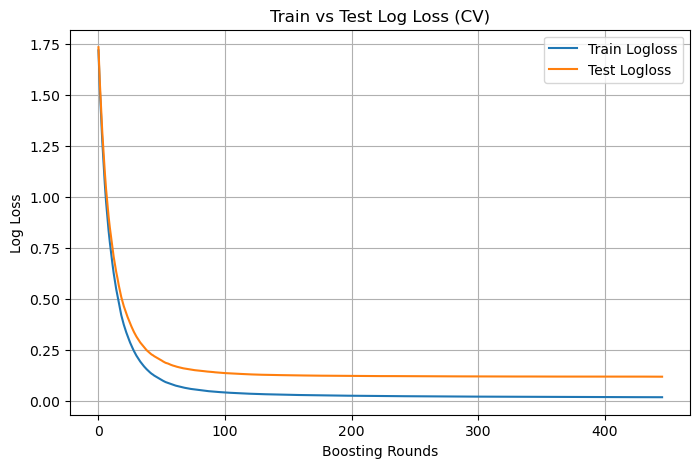

In [6]:
dtrain = xgb.DMatrix(X_train_t, label=y_train)
dtest = xgb.DMatrix(X_test_t, label=y_test)

num_classes = len(np.unique(y_train))

params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "eval_metric": "mlogloss",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "min_child_weight": 3,
    "lambda": 1,
    "alpha": 0.1,
    "seed": 42,
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=30,
    metrics="mlogloss",
    as_pandas=True,
    seed=42,
    verbose_eval=50
)

best_round = cv_results.shape[0]
print(f"\n🏆 Best iteration: {best_round}")

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(cv_results["train-mlogloss-mean"], label="Train Logloss")
plt.plot(cv_results["test-mlogloss-mean"], label="Test Logloss")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Train vs Test Log Loss (CV)")
plt.legend()
plt.grid(True)
plt.savefig(f"shap_plots/XGBoost_train_test_loss.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. Train the final model

In [7]:
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_round
)

## 7. Calculate the accuracy

In [8]:
# Training accuracy
y_pred_train = np.argmax(final_model.predict(dtrain), axis=1)
y_pred_test = np.argmax(final_model.predict(dtest), axis=1)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Testing Accuracy: {test_acc:.4f}")

Testing Accuracy: 0.9456


## 8. Calculate the metris: precision, recall and f1

In [9]:
precision = precision_score(y_test, y_pred_test, average="weighted")
recall = recall_score(y_test, y_pred_test, average="weighted")
f1 = f1_score(y_test, y_pred_test, average="weighted")

print("\nMetrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Metrics:
Precision: 0.9484
Recall:    0.9456
F1-score:  0.9458


## 9. The confusion matrix

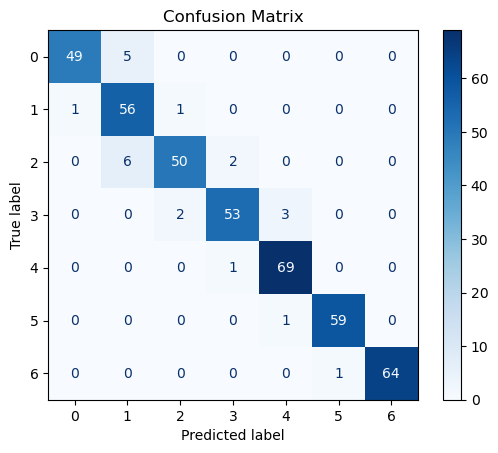

In [10]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(f"shap_plots/XGBoost_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

## 10. ROC AUC

In [11]:
y_test_proba = final_model.predict(dtest)
try:
    roc_auc = roc_auc_score(
        y_test, y_test_proba, multi_class="ovr", average="macro"
    )
    print(f"ROC AUC (macro): {roc_auc:.4f}")
except Exception as e:
    print("ROC AUC could not be computed:", e)

ROC AUC (macro): 0.9963


## 11. Save the model

In [12]:
joblib.dump((final_model, preprocessor), "best_xgb_model.pkl")

['best_xgb_model.pkl']

## 12. SHAP Analysis

SHAP values shape: (423, 31, 7)
Plotting SHAP for class 0


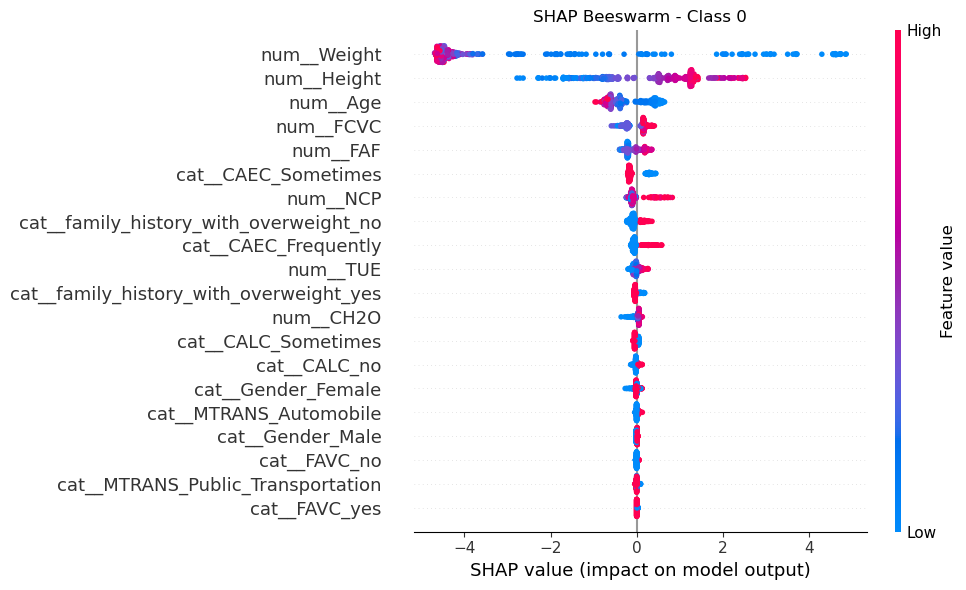

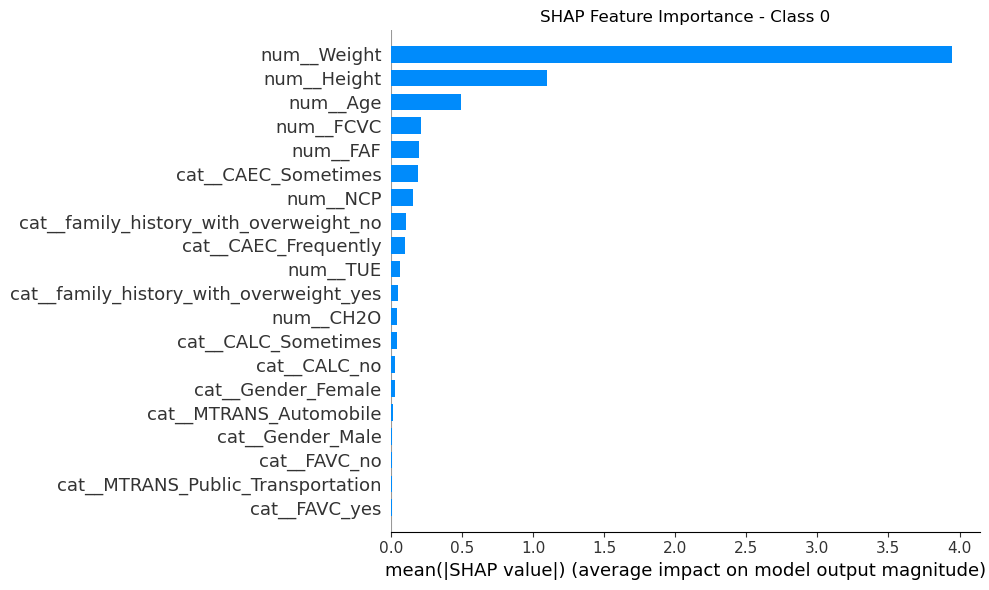

Plotting SHAP for class 1


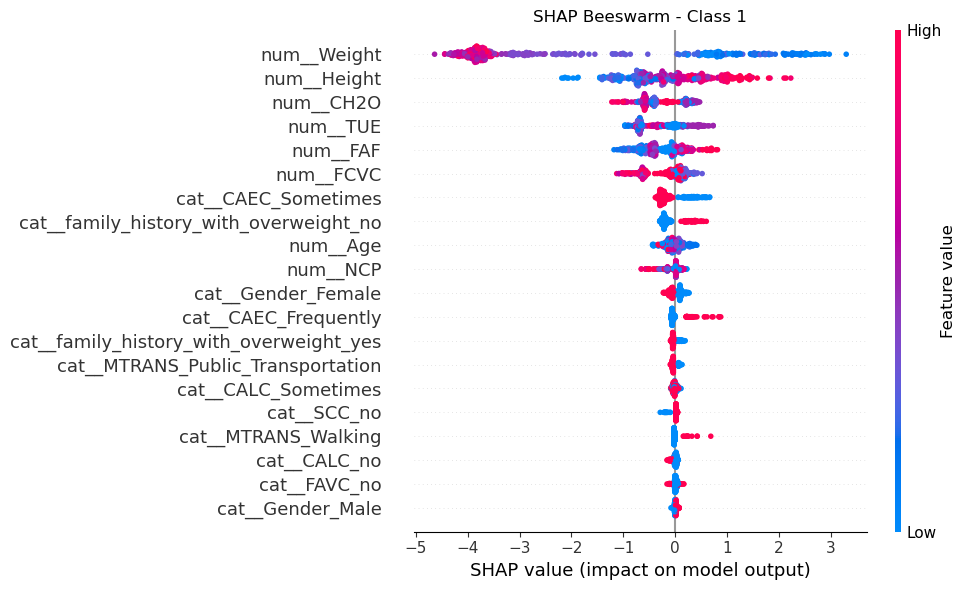

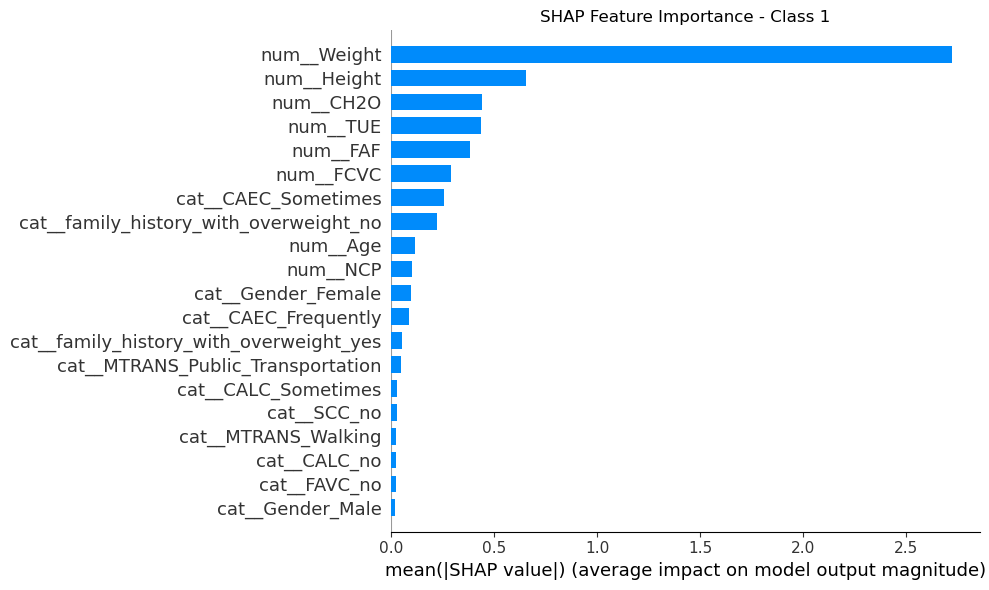

Plotting SHAP for class 2


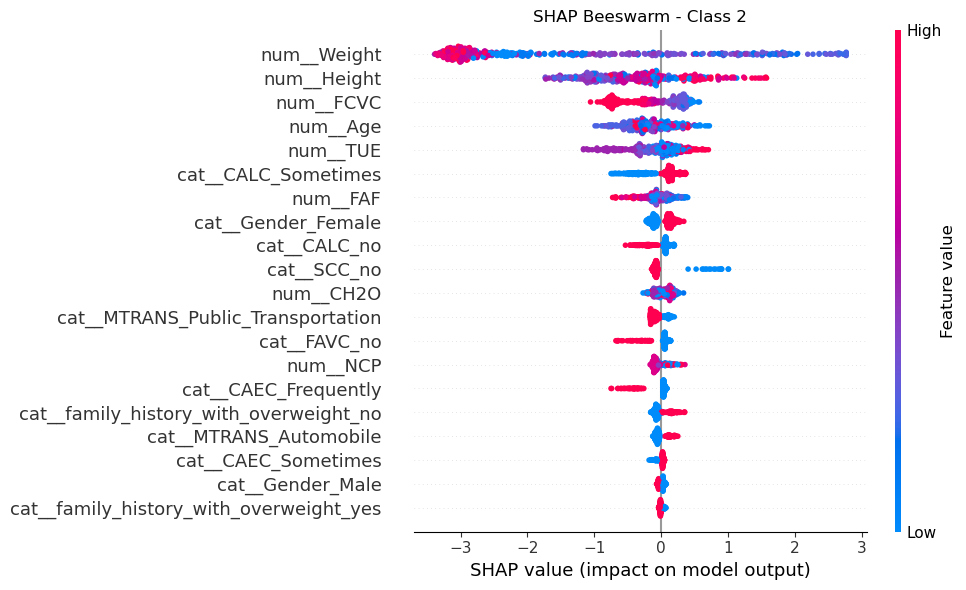

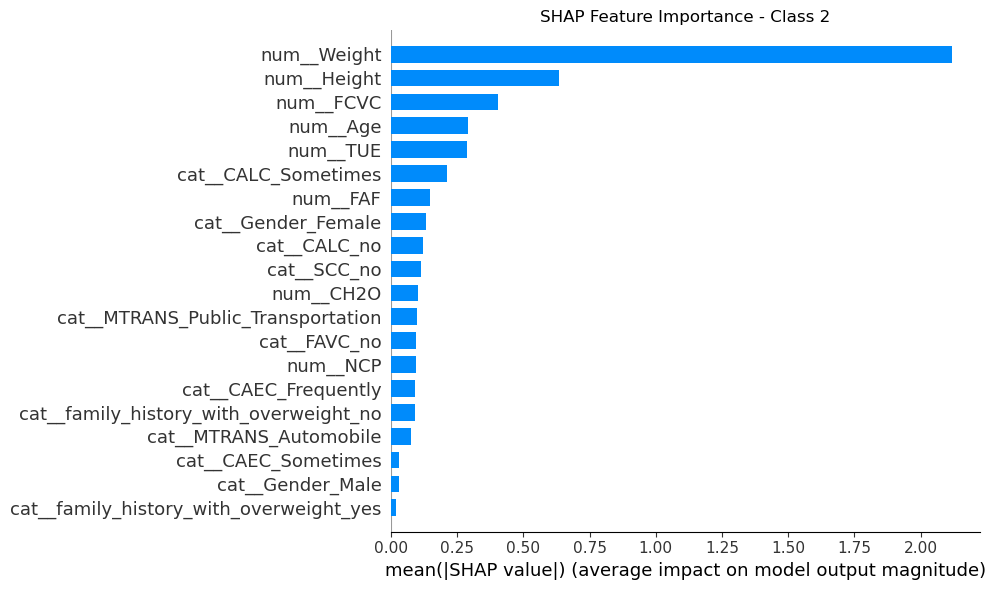

Plotting SHAP for class 3


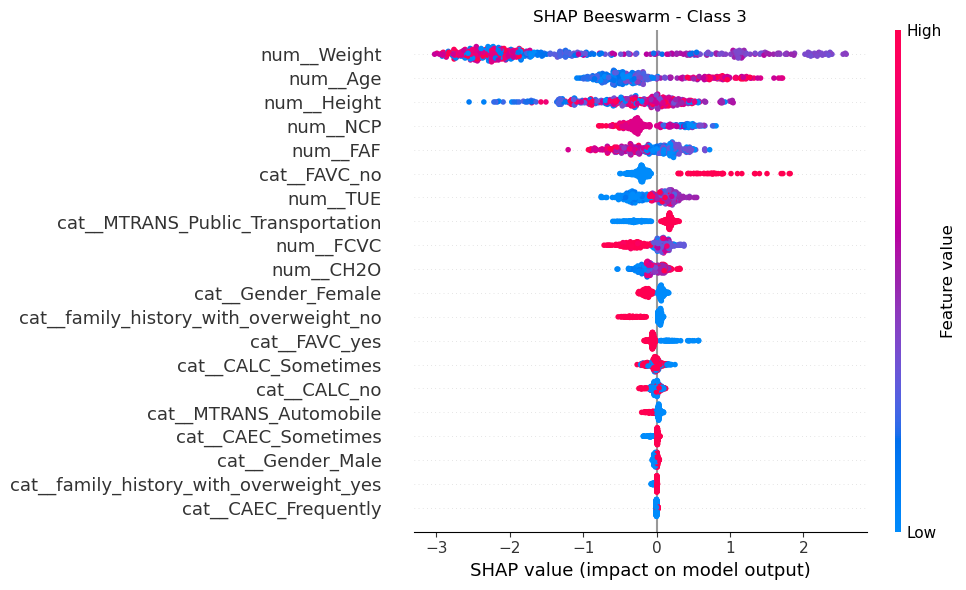

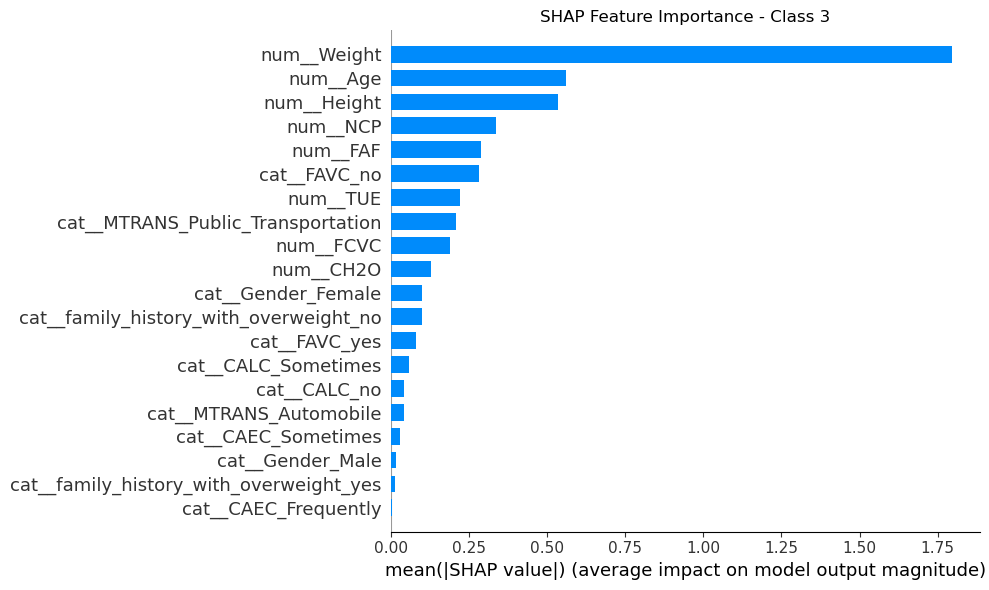

Plotting SHAP for class 4


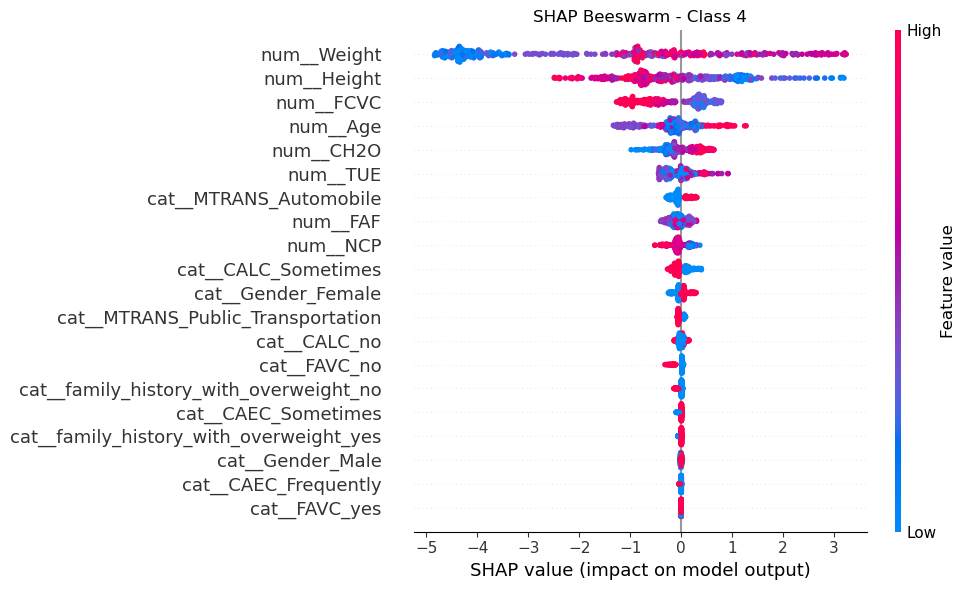

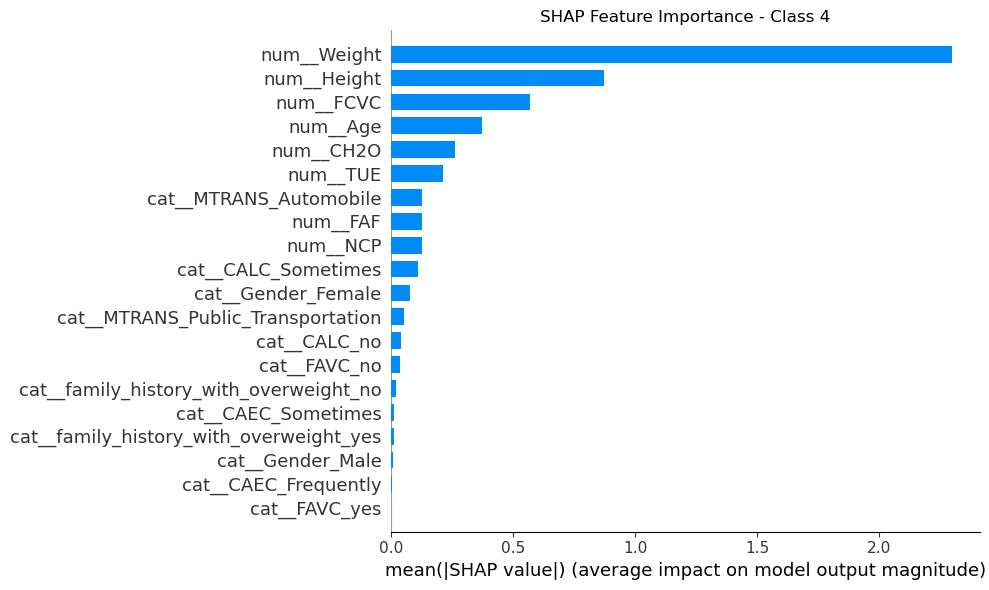

Plotting SHAP for class 5


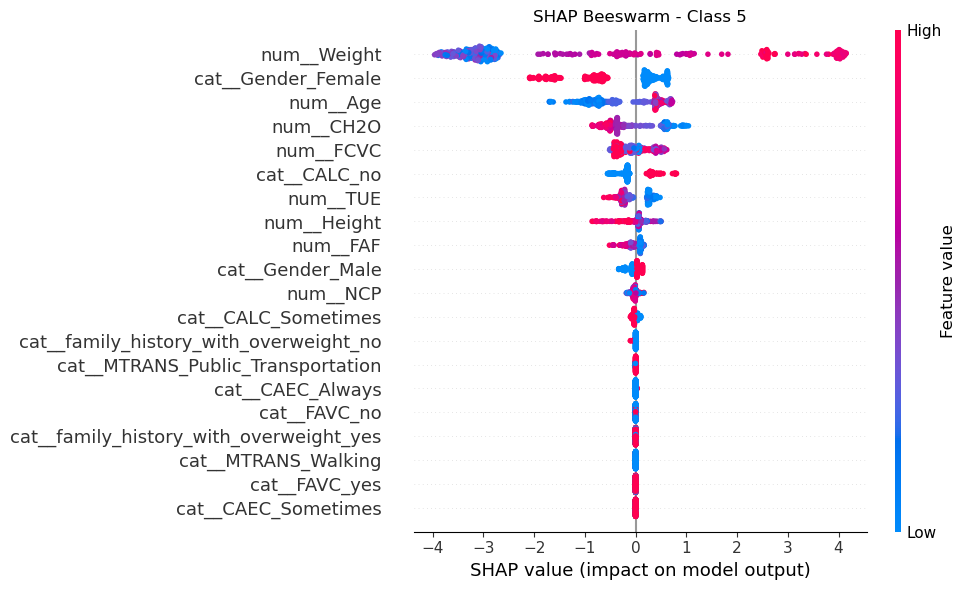

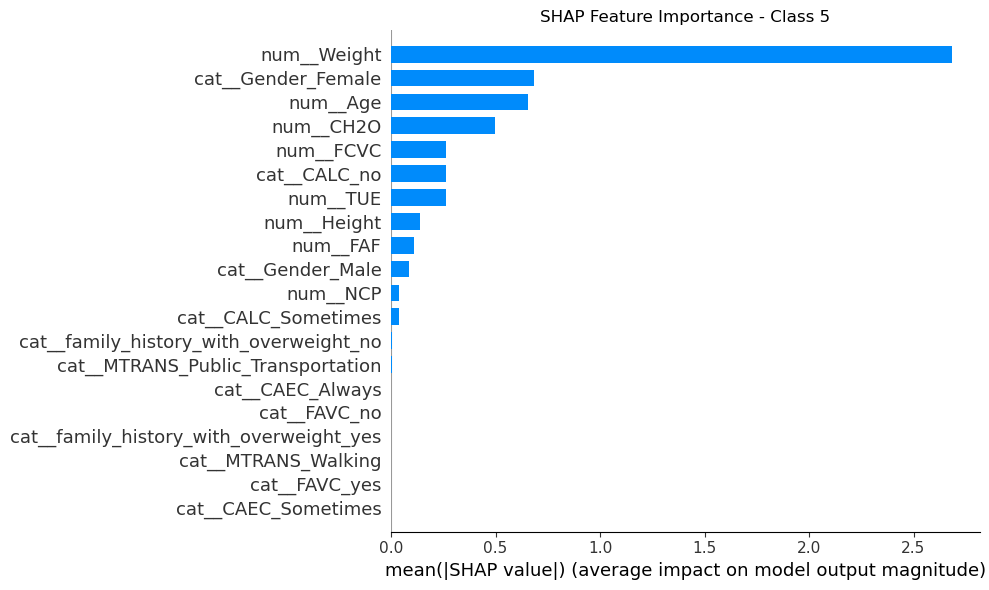

Plotting SHAP for class 6


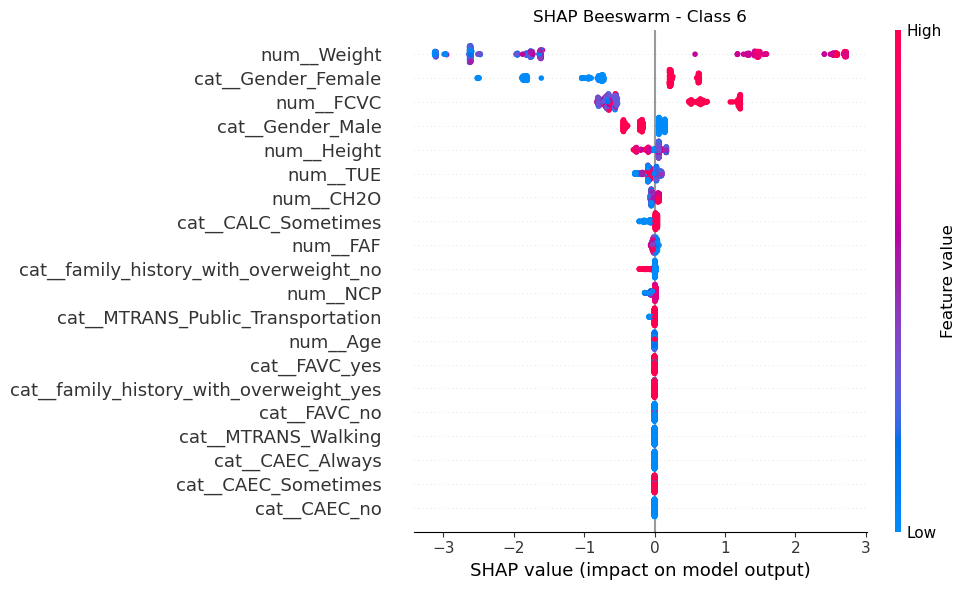

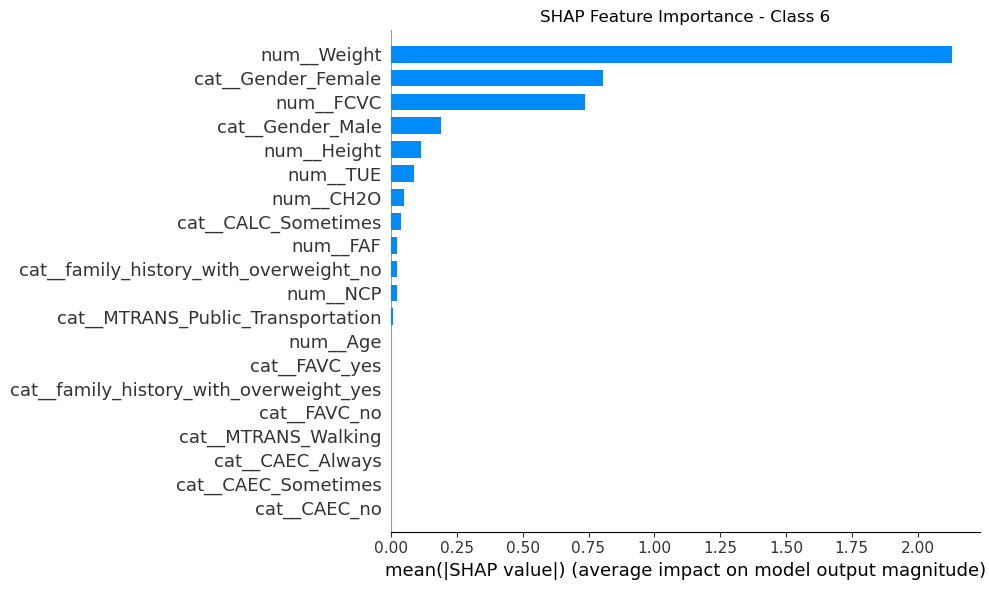

In [13]:
# Initialize TreeExplainer
explainer = shap.TreeExplainer(final_model)

# Get SHAP values (3D array: samples × features × classes)
shap_values = explainer.shap_values(X_test_t)

# Ensure correct shape
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    print(f"SHAP values shape: {shap_values.shape}")
    # shape = (n_samples, n_features, n_classes)
else:
    raise ValueError("Unexpected SHAP value shape:", np.shape(shap_values))

feature_names = preprocessor.get_feature_names_out()

# Create folder for plots
import os
os.makedirs("shap_plots", exist_ok=True)

# Create reproducible random generator
rng = np.random.default_rng(42)

# Loop over classes
for i in range(num_classes):
    print(f"Plotting SHAP for class {i}")
    class_shap = shap_values[:, :, i]

    # Beeswarm Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        class_shap,
        X_test_t,
        feature_names=feature_names,
        show=False,
        plot_size=(10, 6),
        rng=rng  
    )
    plt.title(f"SHAP Beeswarm - Class {i}")
    plt.tight_layout()
    plt.savefig(f"shap_plots/XGBoost_shap_beeswarm_class_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Bar Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        class_shap,
        X_test_t,
        feature_names=feature_names,
        plot_type="bar",
        show=False,
        plot_size=(10, 6),
        rng=rng  
    )
    plt.title(f"SHAP Feature Importance - Class {i}")
    plt.tight_layout()
    plt.savefig(f"shap_plots/XGBoost_shap_bar_class_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()